In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from skimage import io

In [3]:
img_folder = '../data/datasets/VKT_square/augment/augmented_train_images/'
mask_folder = '../data/datasets/VKT_square/augment/augmented_train_masks/'

img_names = !ls $img_folder
mask_names = !ls $mask_folder

In [4]:
images = [io.imread(img_folder + name).astype(float32) / 255 for name in img_names]
masks = [io.imread(mask_folder + name).astype(float32) / 255 for name in mask_names]

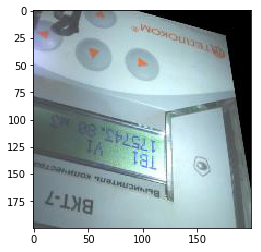

In [5]:
imshow(images[0])

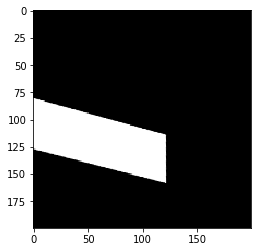

In [6]:
imshow(masks[0], cmap='gray')

In [7]:
import tensorflow as tf
from tensorflow import layers

In [8]:
def conv_layer(inputs, n_filters, stride=1, filter_size=3, activation=tf.nn.elu,
         scope=None, momentum=0.999, epsilon=1e-5, training=True):
    
    batch_size, height, width, n_channels = [int(d) for d in inputs.get_shape()]
    
    with tf.variable_scope(scope, default_name='conv_layer'):
        initializer = tf.truncated_normal_initializer()
        
        kernel_shape = (filter_size, filter_size, n_channels, n_filters)
        kernel_weights = tf.get_variable('kernel', kernel_shape, tf.float32, initializer)
        
        conv = tf.nn.conv2d(inputs, kernel_weights, [1, stride, stride, 1], 'SAME', name='convolution')
        
        running_mean = tf.get_variable(
            'running_mean', (n_filters,), 
            tf.float32, tf.constant_initializer(0),
            trainable=False,
        )
        
        running_var = tf.get_variable(
            'running_var', (n_filters,), 
            tf.float32, tf.constant_initializer(1),
            trainable=False,
        )
        
        if training:
            with tf.variable_scope('update_moments'):
                batch_mean, batch_var = tf.nn.moments(conv, (0, 1, 2))
                new_mean = running_mean*momentum + batch_mean*(1-momentum)
                new_var = running_var * momentum + batch_var*(1-momentum)
                running_mean = tf.assign(running_mean, new_mean, name='update_mean')
                running_var = tf.assign(running_var, new_var, name='update_var')
            
        mean_normalized = tf.subtract(conv, running_mean, name='normalize_mean')
        reciporal_stddev = tf.rsqrt(running_var + epsilon, 'reciprocal_stddev')
        var_normalized = tf.multiply(mean_normalized, reciporal_stddev, 'normalize_var')
        
        gamma = tf.get_variable(
            'gamma', (n_filters,), 
            tf.float32, tf.constant_initializer(1),
            trainable=False,
        )
        
        beta = tf.get_variable(
            'beta', (n_filters,), 
            tf.float32, tf.constant_initializer(0),
            trainable=False,
        )
        
        scaled = tf.multiply(var_normalized, gamma, 'scale')
        shifted = tf.nn.bias_add(scaled, beta, 'NHWC', 'shift')
        
        if activation:
            activated = activation(shifted, 'activation')
        else:
            activated = shifted
        
    return activated

In [9]:
def upconv_layer(inputs, n_filters, stride=1, filter_size=3, activation=tf.nn.elu,
         scope=None, momentum=0.999, epsilon=1e-5, training=True):
    
    batch_size, height, width, n_channels = [int(d) for d in inputs.get_shape()]
    
    with tf.variable_scope(scope, default_name='conv_layer'):
        initializer = tf.truncated_normal_initializer()
        
        kernel_shape = (filter_size, filter_size, n_filters, n_channels)
        kernel_weights = tf.get_variable('kernel', kernel_shape, tf.float32, initializer)
        
        conv = tf.nn.conv2d_transpose(inputs, kernel_weights, [batch_size, height * stride, width * stride, n_filters],
                                      [1, stride, stride, 1], 'SAME', name='convolution')
        
        running_mean = tf.get_variable(
            'running_mean', (n_filters,), 
            tf.float32, tf.constant_initializer(0),
            trainable=False,
        )
        
        running_var = tf.get_variable(
            'running_var', (n_filters,), 
            tf.float32, tf.constant_initializer(1),
            trainable=False,
        )
        
        if training:
            with tf.variable_scope('update_moments'):
                batch_mean, batch_var = tf.nn.moments(conv, (0, 1, 2))
                new_mean = running_mean*momentum + batch_mean*(1-momentum)
                new_var = running_var*momentum + batch_var*(1-momentum)
                running_mean = tf.assign(running_mean, new_mean, name='update_mean')
                running_var = tf.assign(running_var, new_var, name='update_var')
            
        mean_normalized = tf.subtract(conv, running_mean, name='normalize_mean')
        reciporal_stddev = tf.rsqrt(running_var + epsilon, 'reciprocal_stddev')
        var_normalized = tf.multiply(mean_normalized, reciporal_stddev, 'normalize_var')
        
        gamma = tf.get_variable(
            'gamma', (n_filters,), 
            tf.float32, tf.constant_initializer(1),
            trainable=False,
        )
        
        beta = tf.get_variable(
            'beta', (n_filters,), 
            tf.float32, tf.constant_initializer(0),
            trainable=False,
        )
        
        scaled = tf.multiply(var_normalized, gamma, 'scale')
        shifted = tf.nn.bias_add(scaled, beta, 'NHWC', 'shift')
        
        if activation:
            activated = activation(shifted, 'activation')
        else:
            activated = shifted
        
    return activated

![layers.jpg](https://i.imgur.com/ktUOnca.jpg)

In [10]:
def model_def(inputs, training=True):
        
    conv200to100 = conv_layer(inputs, 64, 2, 7, training=training, scope='conv200to100')
    conv100_1 = conv_layer(conv200to100, 64, 1, 3, training=training, scope='conv100_1')
    conv100_2 = conv_layer(conv100_1, 64, 1, 3, training=training, scope='conv100_2')
    conv100_3 = conv_layer(conv100_2, 64, 1, 3, training=training, scope='conv100_3')
    
    conv100to50 = conv_layer(conv100_3, 128, 2, 3, training=training, scope='conv100to50')
    conv50_1 = conv_layer(conv100to50, 128, 1, 3, training=training, scope='conv50_1')
    conv50_2 = conv_layer(conv50_1, 128, 1, 3, training=training, scope='conv50_2')
    conv50_3 = conv_layer(conv50_2, 128, 1, 3, training=training, scope='conv50_3')
    
    conv50to25 = conv_layer(conv50_2, 256, 2, 3, training=training, scope='conv50to25')
    conv25_1 = conv_layer(conv50to25, 256, 1, 3, training=training, scope='conv25_1')
    conv25_2 = conv_layer(conv25_1, 256, 1, 3, training=training, scope='conv25_2')
    conv25_3 = conv_layer(conv25_2, 256, 1, 3, training=training, scope='conv25_3')
    conv25_4 = conv_layer(conv25_3, 256, 1, 3, training=training, scope='conv25_4')
    conv25_5 = conv_layer(conv25_4, 256, 1, 3, training=training, scope='conv25_5')
    
    conv25to50 = upconv_layer(conv25_5, 128, 2, 3, training=training, scope='conv25to50')
    joint50 = tf.concat([conv25to50, conv50_3], 3, 'join50')
    conv50_4 = conv_layer(joint50, 128, 1, 3, training=training, scope='conv50_4')
    conv50_5 = conv_layer(conv50_4, 128, 1, 3, training=training, scope='conv50_5')
    conv50_6 = conv_layer(conv50_5, 128, 1, 3, training=training, scope='conv50_6')
    
    conv50to100 = upconv_layer(conv50_6, 32, 2, 3, training=training, scope='conv50to100')
    joint100 = tf.concat([conv50to100, conv100_3], 3, 'join100')
    conv100_4 = conv_layer(joint100, 32, 1, 3, training=training, scope='conv100_4')
    conv100_5 = conv_layer(conv100_4, 32, 1, 3, training=training, scope='conv100_5')
    conv100_6 = conv_layer(conv100_5, 32, 1, 3, training=training, scope='conv100_6')
    
    conv100to200 = upconv_layer(conv100_6, 32, 2, 3, training=training, scope='conv100to200')
    logits = conv_layer(conv100to200, 1, 1, 3, training=training, scope='logits', activation=None)
    
    return logits

In [11]:
image_batch = tf.placeholder(tf.float32, (64, 200, 200, 3))
mask_batch = tf.placeholder(tf.float32, (64, 200, 200))
mask_batch_reshaped = mask_batch[:, :, :, tf.newaxis]

logits = model_def(image_batch)

loss_per_pixel = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=mask_batch_reshaped)
loss = tf.reduce_mean(loss_per_pixel)

In [12]:
from tensorflow import train

In [13]:
opt = train.AdamOptimizer()

In [14]:
step = tf.get_variable('step', [], tf.int32, tf.constant_initializer(0, dtype=tf.int32))

In [15]:
optimize_op = opt.minimize(loss, step)

In [16]:
sess = tf.InteractiveSession()

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
def train_one_epoch():
    for i in range(0, len(images), 64):
        if i + 64 >= len(images):
            break
        _, loss_val = sess.run([optimize_op, loss], {image_batch: images[i:i+64], mask_batch: masks[i:i+64]})
        print '\r{}'.format(loss_val)

In [31]:
train_one_epoch()

0.141158223152
0.140999391675
0.176729768515
0.123173266649
0.19397059083
0.13059130311
0.151674896479
0.138409718871
0.107105888426
0.157076656818
0.136924996972
0.13365469873
0.148797094822
0.194268912077
0.180743128061
0.116759307683
0.122097961605
0.193651691079
0.139244556427
0.165932968259
0.152191966772
0.116907484829
0.211967021227
0.305192172527
0.12774476409
0.137750327587
0.17589789629
0.164316862822
0.12394964695
0.152830556035
0.210114791989
0.137131169438
0.168855249882
0.16626855731
0.584881544113
0.189741119742
0.18040291965
0.162756279111
0.192623332143
0.140205726027
0.188163384795
0.127838373184
0.298050493002
0.209511175752
0.287307113409
0.133320271969
0.302652955055
0.261277109385
0.205043077469
0.156954541802
0.170295342803
0.223909854889
0.183757349849
0.21514287591
0.159396439791
0.154696986079
0.183197125793
0.168941929936
0.213255703449
0.153568848968
0.222769767046
0.245541080832
0.170901492238
0.164177104831
0.282577037811
0.181837797165
0.16175660491
0.166

In [41]:
test = sess.run(logits, {image_batch: images[len(images)-64:], mask_batch: masks[len(images)-64:]})

In [ ]:
test_folder = '../data/datasets/VKT_square/augment/test_images/'

In [61]:
test_img_folder = '../data/datasets/VKT_square/augment/test_images/'
test_mask_folder = '../data/datasets/VKT_square/augment/test_masks/'

test_img_names = !ls $test_img_folder
test_mask_names = !ls $test_mask_folder
test_images = [io.imread(test_img_folder + name).astype(float32) / 255 for name in test_img_names]
test_masks = [io.imread(test_mask_folder + name).astype(float32) / 255 for name in test_mask_names]

In [62]:
test = sess.run(logits, {image_batch: test_images[len(test_images)-64:], mask_batch: test_masks[len(test_images)-64:]})

ValueError: setting an array element with a sequence.

In [58]:
imshow(test_images[len(test_images)-64 +10])

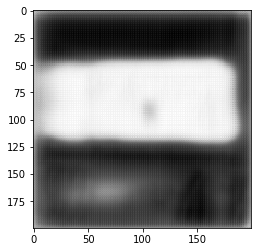

In [59]:
imshow(test[10, :, :, 0], cmap='gray');

In [8]:
sess.run(test, {inputs: zeros((1, 10, 10, 3))})

array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        ..., 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0., 